In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("train.csv")
pd.set_option('display.max_columns', 500)
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [4]:
rows = train.shape[0]
columns = train.shape[1]
print("The train dataset contains {0} rows and {1} columns".format(rows, columns))

The train dataset contains 595212 rows and 59 columns


According to GDPR, the data is protection by the use of data protection pipeline.

Target : The column we want to predict
_cat : Categorical 
_bin : Binary
_ind : Individual
_reg : Regional (Continuous Distribution)
_car : Car level characteristics
_calc : Calculations

Many times null is replaced by negative values so you need to make these things sure

In [5]:
train.isnull().sum().sum()

0

In [6]:
train1 = train.copy()
train1 = train1.replace(-1, np.NaN)

<AxesSubplot:>

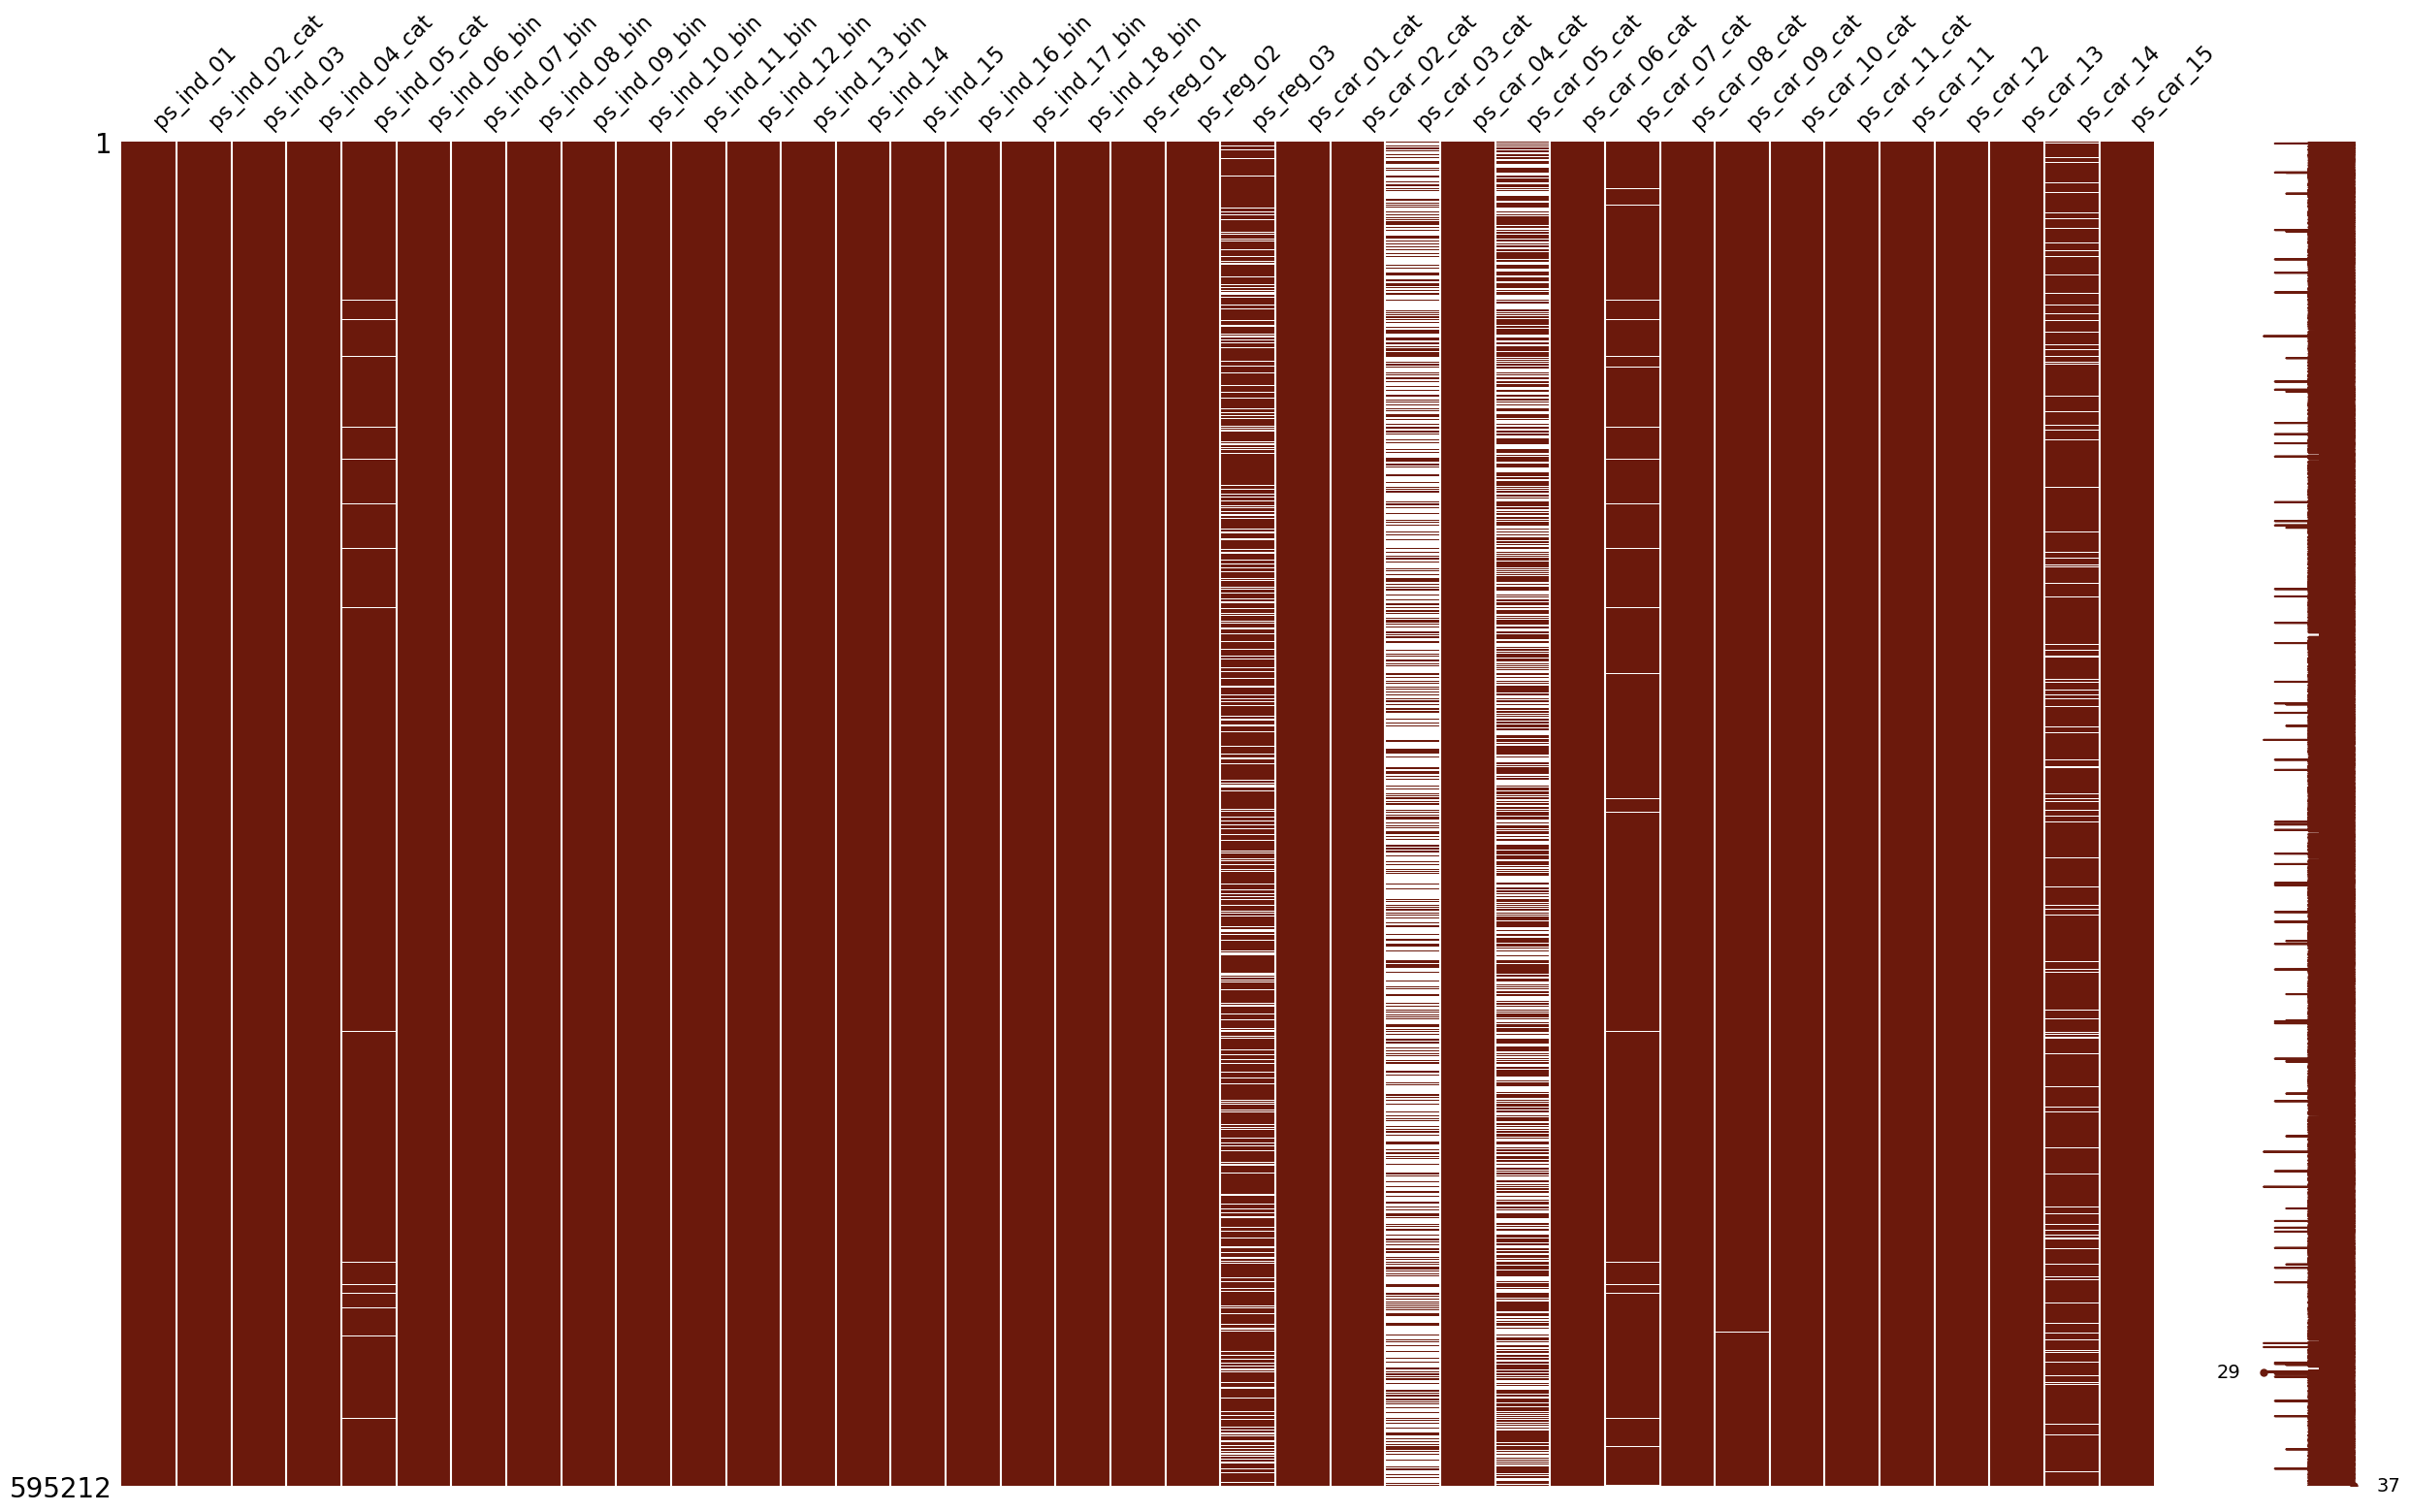

In [7]:
import missingno as msno

msno.matrix(df=train1.iloc[:,2:39], figsize=(30,18), color=(0.42, 0.1, 0.05))

<AxesSubplot:>

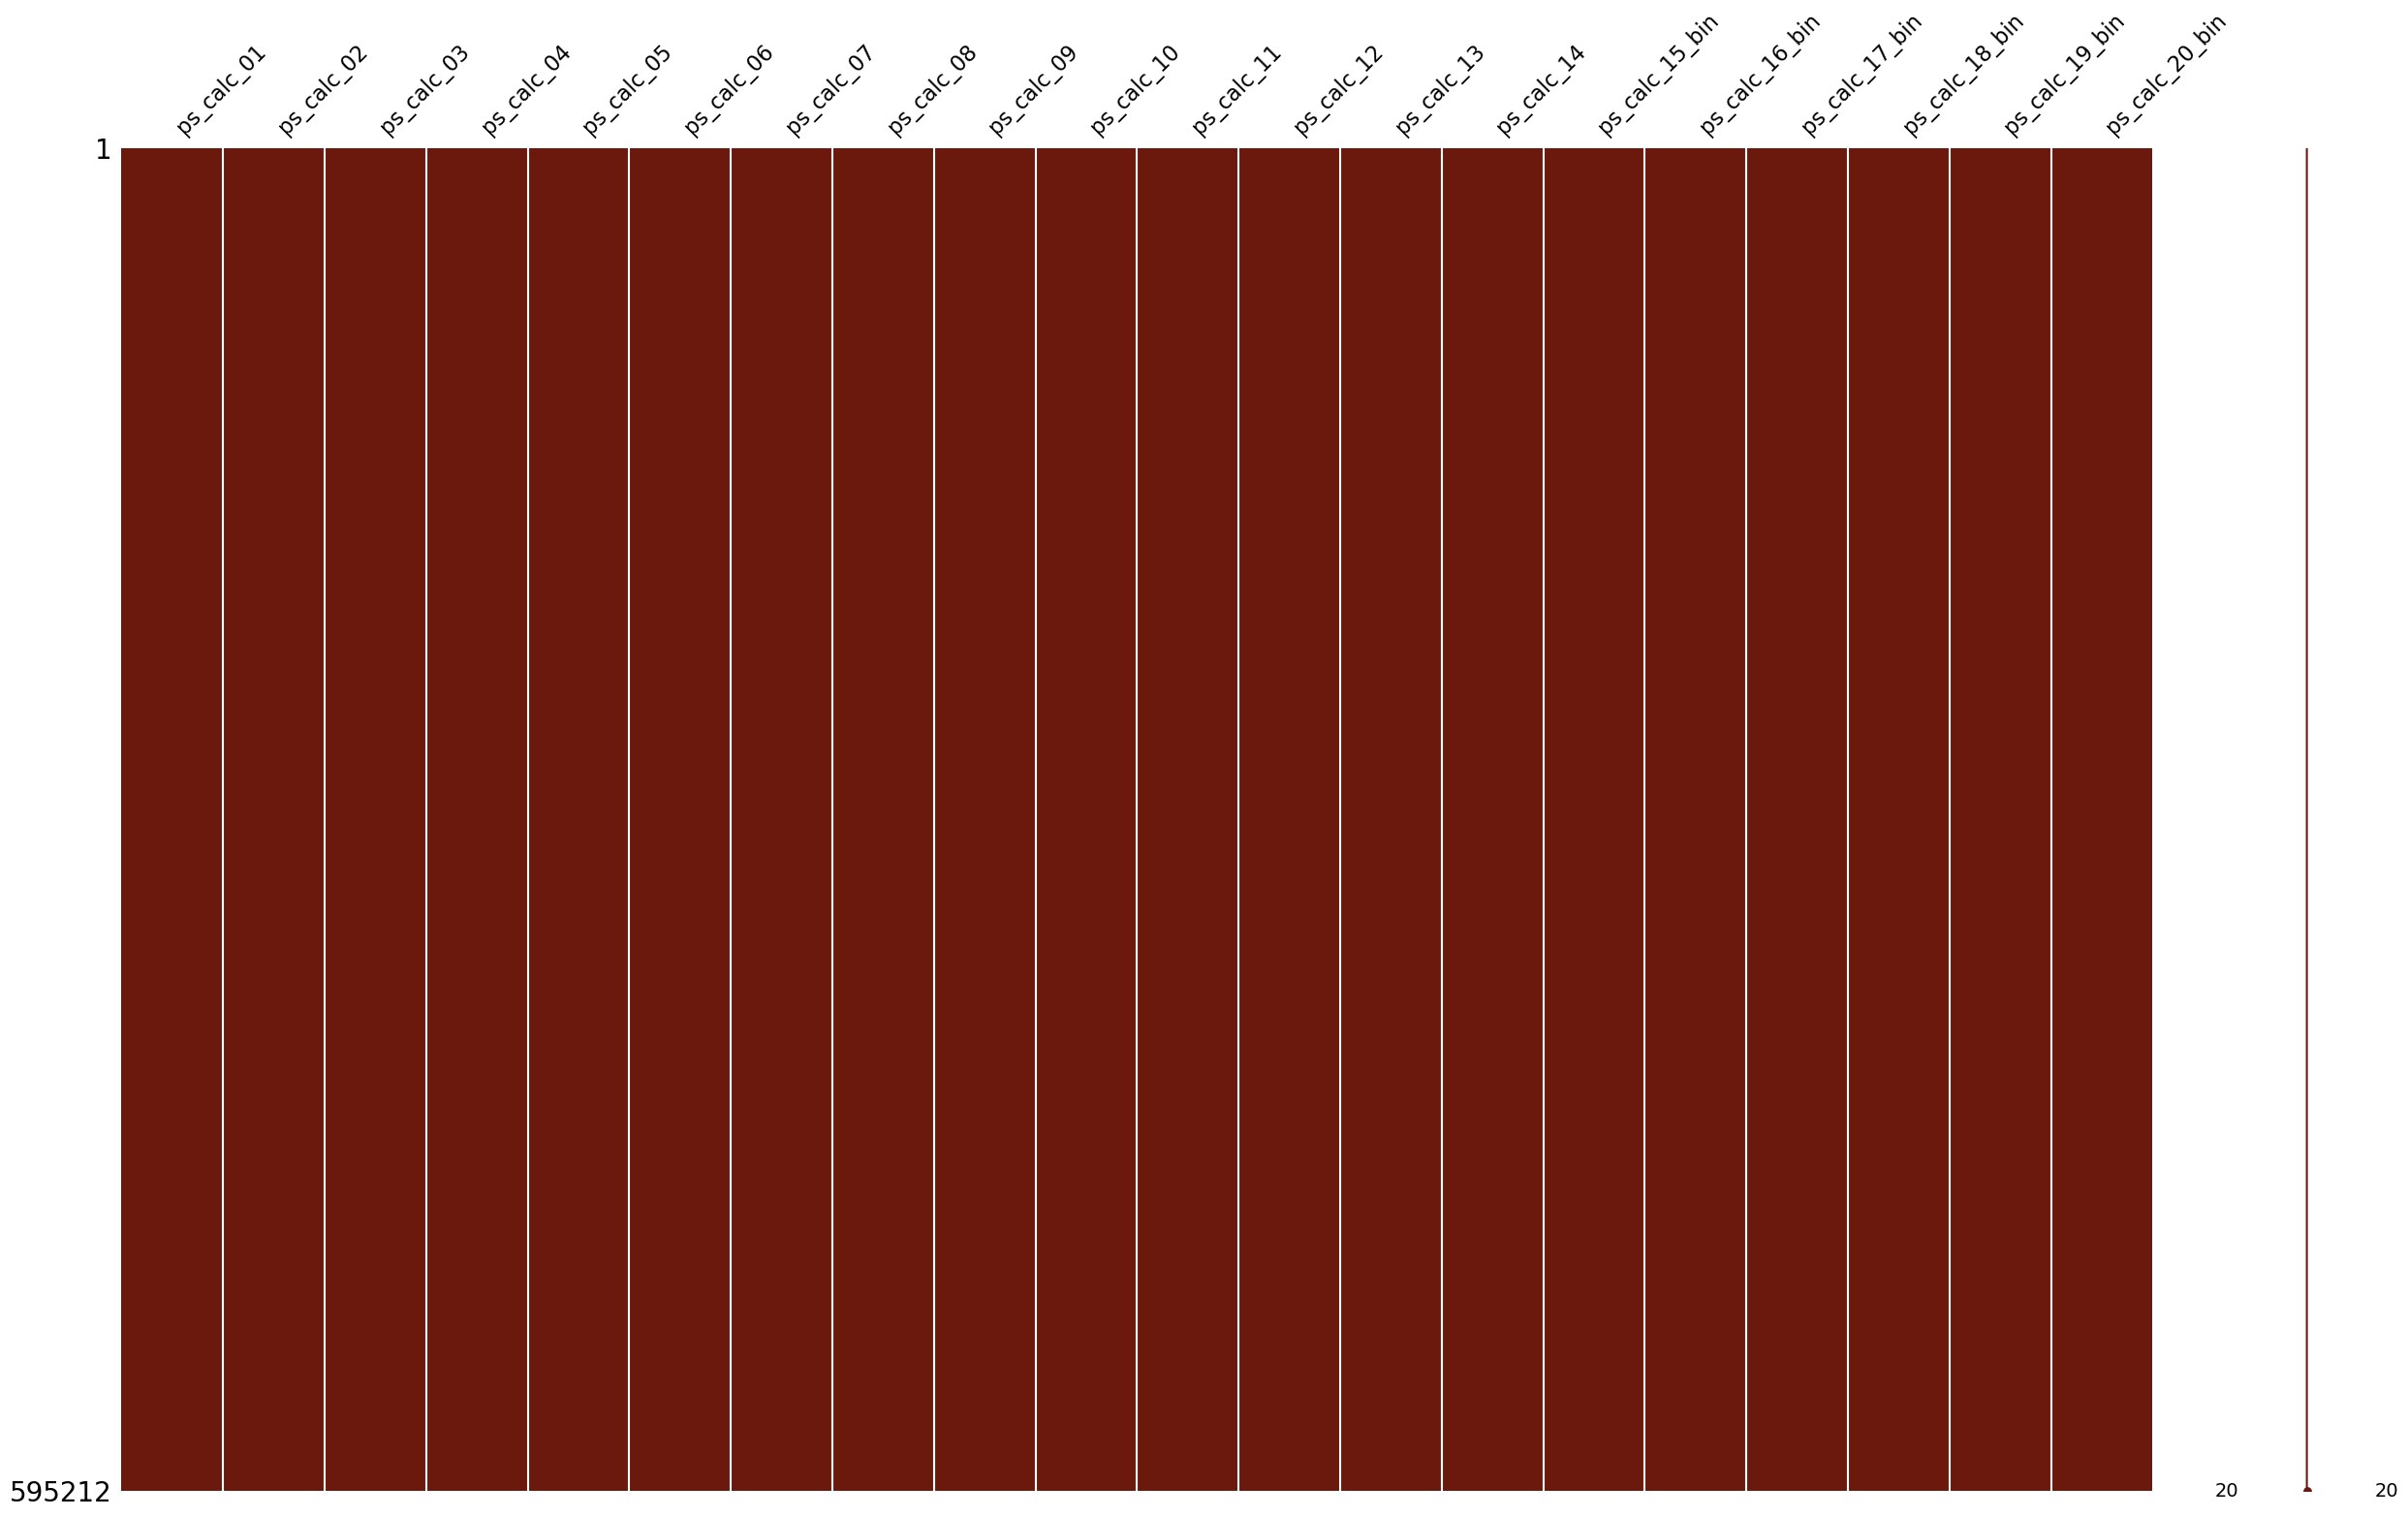

In [8]:
msno.matrix(df=train1.iloc[:,39:], figsize=(30,18), color=(0.42, 0.1, 0.05))

Hence, we can observe that the null values are in the column, ps_ind_05_cat, ps_reg_03, ps_car_03_cat, ps_car_05_cat, ps_car_07_cat, ps_car_09_cat, ps_car_14

### Target Variable Inspection

In [9]:
data = [go.Bar(
    x = train1["target"].value_counts().index.values,
    y = train1["target"].value_counts(),
    text = "Distribution of target variable"
)]

layout = go.Layout(
    title="Target variable distribution"
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="basic-bar")

In [10]:
train1['target'].value_counts()/train.shape[0]*100

0    96.355248
1     3.644752
Name: target, dtype: float64

There is a data imbalance problem.We cannot use precision and recall as a validation metric.

E.g., there is a Binary Classification with 10000 rows. Out of these 10000 rows of data, only 100 is 1 and rest of them is 0. In such case, if you consider all of them to be 0, your accuracy will be 99%. So you cannot use Accuracy or Decision Boundary as a metric. Thus, we can use AUC, i.e., area under the curve, as a metric. 

Reason: AUC uses sensitivity and specifity, which plots all the possible decision boundaries and finds the answers.

You can also use Gini instead of AUC. See the formula.

In [11]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

In [12]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

### Correlation Plot

<AxesSubplot:title={'center':'Pearson correlation of continuous features'}>

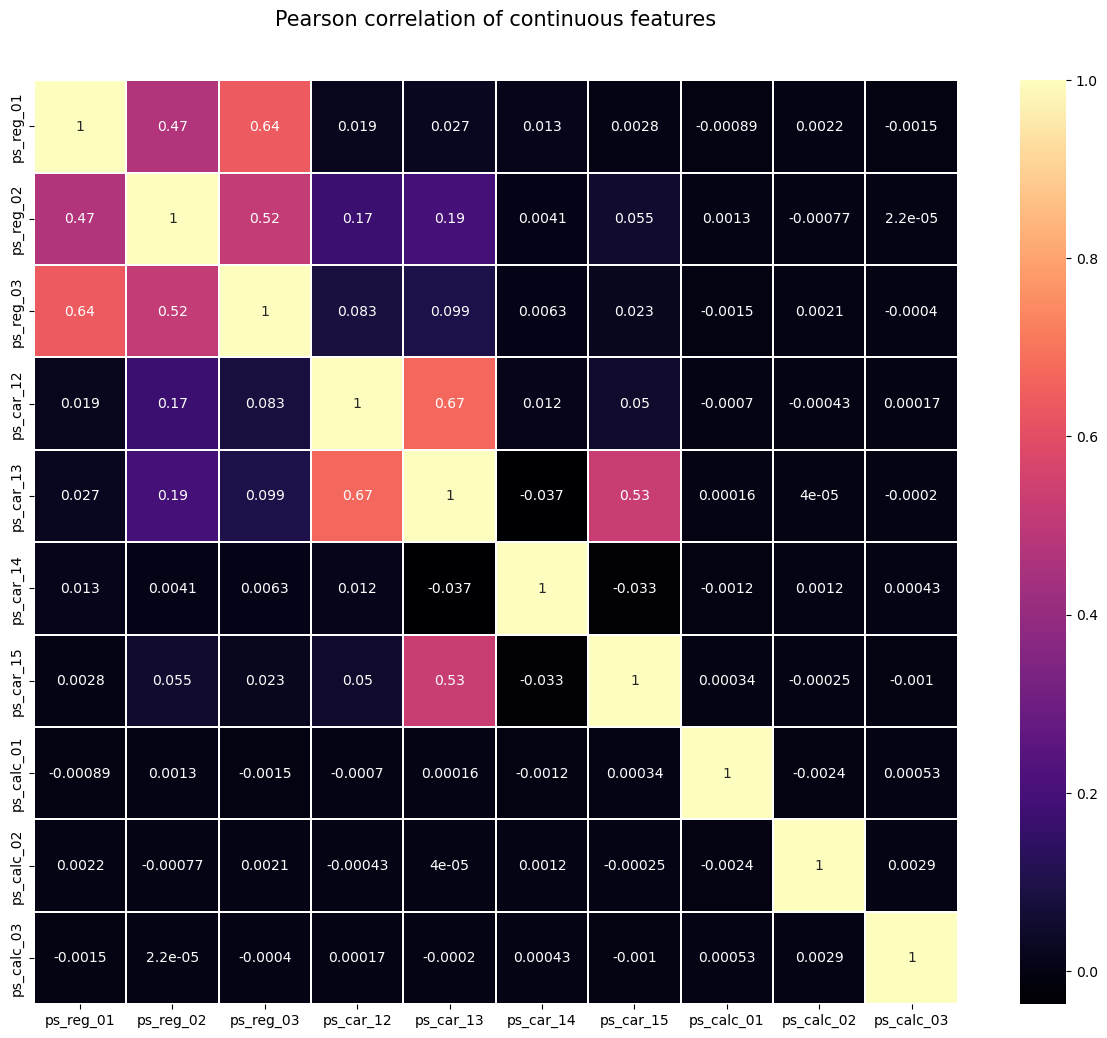

In [13]:
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title("Pearson correlation of continuous features", y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True)

We can observe that there is a little correlation between ps_reg_01 and ps_reg_02, ps_reg_01 and ps_reg_03, ps_reg_02 and ps_reg_03, ps_car_13 and ps_car_12, ps_car_15 and ps_car_13.

### Correlation between integer features

In [14]:
data = [
    go.Heatmap(
        z = train_int.corr().values,
        x = train_int.columns.values,
        y = train_int.columns.values,
        colorscale = 'Viridis',
        reversescale = False,
        text = [True],
        opacity = 1.0
    )
]

layout = go.Layout(
    title = "Pearson Correlation of Integer-type features",
    xaxis = dict(ticks = '', nticks = 36),
    yaxis = dict(ticks = ''),
    width = 900,
    height = 700
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'labelled-heatmap')

In [15]:
mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors=3, random_state=17)
print(mf)

[0.02599971 0.00767074 0.00617141 0.01855302 0.00158483 0.00338192
 0.01668813 0.0134428  0.01334669 0.01348572]


### Binary Features Inspection

In [16]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col] == 0).sum())
    one_list.append((train[col]==1).sum())

In [17]:
tracel = go.Bar(
    x = bin_col,
    y = zero_list,
    name = 'Zero count'
)

trace2 = go.Bar(
    x = bin_col,
    y = one_list,
    name = "One count"
)


In [18]:
data = [tracel, trace2]
layout = go.Layout(
    barmode = 'stack',
    title = 'Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Stacked-bar')


Keeping the features with so many 1s might result in overfitting. Generally, as we see this in such a case of Binary Classification, so keeping the ratio of 1 and 0 between 5% and 95%.

One smart trick is to use Feature Importance, by using Random Forest Model and keeping a base line, you can plot the feature importance.

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(['id','target'], axis=1), train.target)
features = train.drop(['id', 'target'], axis = 1).columns.values
print("----- Training Done -------")

----- Training Done -------


In [20]:
# Scatter plot 
trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [21]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

### Decision Tree Visualization

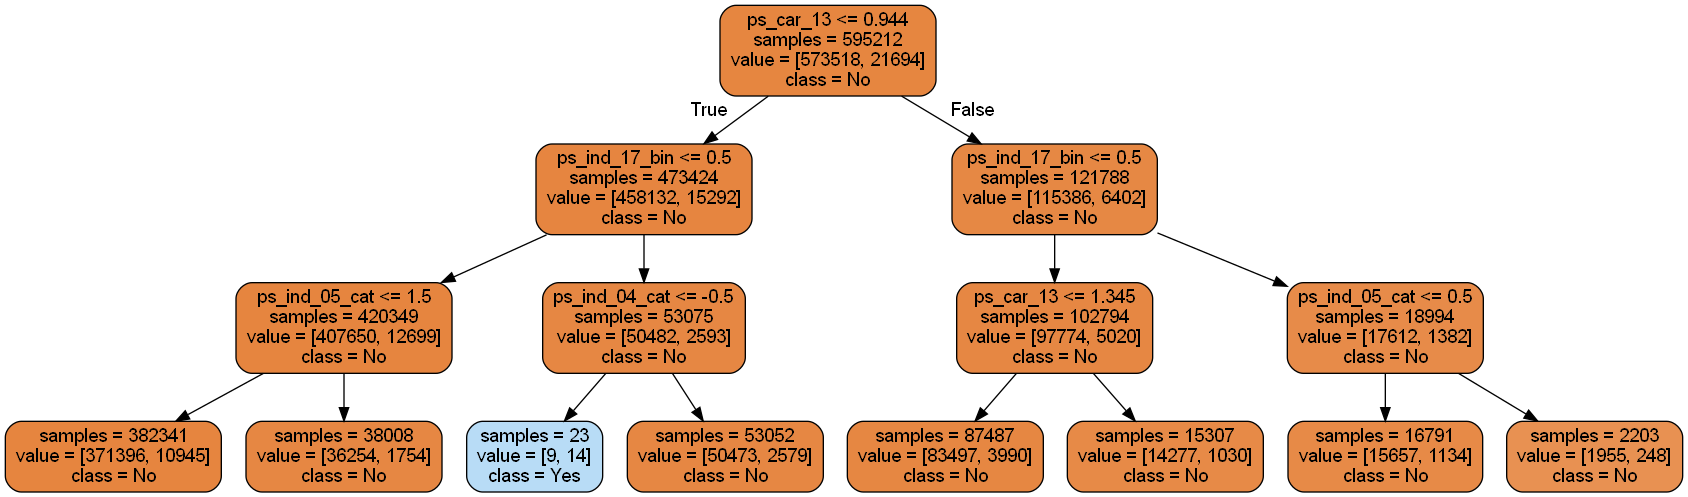

In [22]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(train.drop(['id', 'target'],axis=1), train.target)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = False,
                              feature_names = train.drop(['id', 'target'],axis=1).columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png",)

### Feature Importance by GBM

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100,max_depth = 3, min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train.drop(['id', 'target'], axis = 1), train.target)
features = train.drop(['id', 'target'], axis=1).columns.values
print("---------Training Done------------")

---------Training Done------------


In [24]:
# Scatter plot 
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Machine Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

All of our three algorithms said that these features are of uttermost importance to the dataset, this means that the dataset is following a definite pattern

### To understand when to use Logistic Regression, Decision Tree, or high level algorithms like Deep Learning, Neural Networks

To understand this, we need to do Principal Component Analysis or TSNE visualization

Linear Regression or Logistic Regression Classifier works when our dataset is not that complex

Now how do you visualize whether your dataset is complex or not

PCA : At a very small level we can say like, suppose we have our data in n-dimensional space, and we are projecting on a 2D axis. If my data is linearly separable I will see that my data is properly segregated. Otherwise, if my data is not linearly separable, i.e., it is a lot complex, I won't be able to see trends or patterns in this data.

In [27]:
train.target.unique()

array([0, 1], dtype=int64)